In [51]:
# Example usage:
from invasion import (
    compute_nontrivial_slice,
    simulate_segment,
    compute_deltaW_curve,
    compare_severities,
    test_plot,
    compare_scalers
)

W_birth = 0.4
W_death = 0.1
Y_birth = 0.9
Y_death = 0.15

X_in = 0.2
X_out = 0.1
Z_in = 0.5
Z_out = 0.25

Time = 600.0
dt = 0.1

use_X = True
use_Z = False

num_points = 100
severity = 0.5

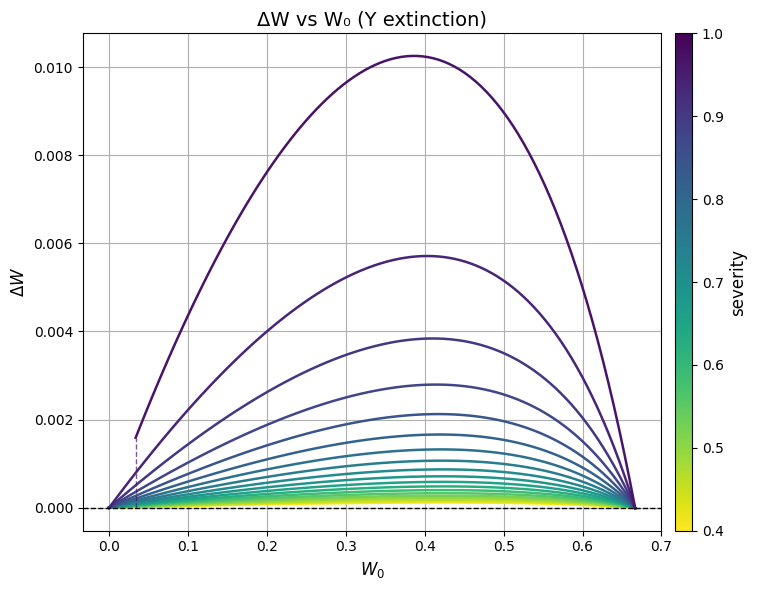

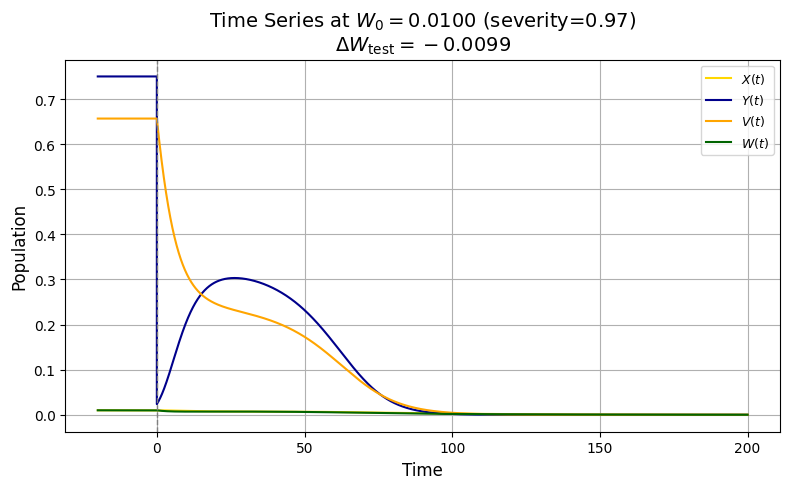

{'W_eq': 0.6666666666666666,
 'Y_eq': 0.7500000000000002,
 'W0': 0.01,
 'V_eq_pre': 0.6566666666666666,
 'W_eq_pre': 0.01,
 'Y_eq_pre': 0.7500000000000002,
 'X_eq_pre': 0.01,
 'Z_eq_pre': None,
 'V_mid': 0.6566666666666666,
 'W_mid': 0.01,
 'Y_mid': 0.023684212500000003,
 't_full': array([-20.  , -19.99, -19.98, ..., 199.98, 199.99, 200.  ]),
 'V_full': array([6.56666667e-01, 6.56666667e-01, 6.56666667e-01, ...,
        2.04718239e-07, 2.04513520e-07, 2.04309007e-07]),
 'W_full': array([0.01      , 0.01      , 0.01      , ..., 0.00013134, 0.0001313 ,
        0.00013127]),
 'Y_full': array([7.50000000e-01, 7.50000000e-01, 7.50000000e-01, ...,
        6.11777932e-10, 6.10860989e-10, 6.09945421e-10]),
 'X_full': array([0.01      , 0.01      , 0.01      , ..., 0.00017941, 0.00017936,
        0.00017931]),
 'Z_full': None,
 'delta_W_test': -0.009868734718842346}

In [4]:
    # Compare severities
compare_severities(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        Time=Time, dt=dt, use_X=use_X, use_Z=use_Z,
        num_points=num_points,
        severity_range=(0.4, 1), n_sev=20,
         perturb_W=False, perturb_Y=True,
        tol=1e-6, verbose=False
    )

    # Test‐plot at W0 = 0.1, with severity interpreted as 1−severity
test_plot(
        W_birth=W_birth, Y_birth=Y_birth,
        W_death=W_death, Y_death=Y_death,
        X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out,
        W0=0.01,
        Time=200.0, dt=0.01,
        use_X=use_X, use_Z=use_Z,
        severity=0.96842105,  # actual shock multiplier = (1 - 0.3) = 0.7
         perturb_W=False, perturb_Y=True,
        perturb_time=20.0,
        tol=1e-6
    )

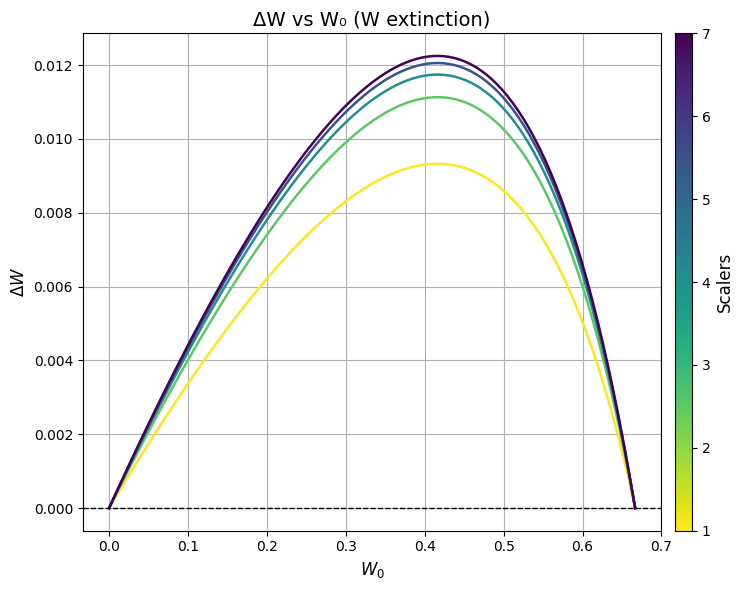

In [7]:

compare_scalers(W_birth, Y_birth, W_death, Y_death,
                       X_in, Z_in, X_out, Z_out, severity=severity,
                       Time=Time, dt=dt,
                       use_X=use_X, use_Z=use_Z, scale_X=True,
                       num_points=num_points,
                       scaler_range=(1, 7), n_scaler=5,
                       perturb_W=True, perturb_Y=False,
                       tol=1e-7,
                       verbose=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def run_cycles(V0, W0, Y0, X0, Z0,
               W_birth, Y_birth, W_death, Y_death,
               X_in, Z_in, X_out, Z_out,
               duration, dt,
               use_X, use_Z,
               cycles,
               severity,
               perturb_W=False,
               perturb_Y=False):
    """
    Run 'cycles' successive calls to simulate_segment, each time:
      1) simulate_segment(...) → (t, V_arr, W_arr, Y_arr, X_arr, Z_arr)
      2) record final V, W, Y
      3) if perturb_W: set W0_next = (1-severity)*W_final and
                         V0_next = (1-severity)*V_final
      4) if perturb_Y: set Y0_next = (1-severity)*Y_final
      5) X0_next = X_final, Z0_next = Z_final
    After all cycles, plot cycle index vs final W, V, and Y.
    Returns lists of final values [V_finals, W_finals, Y_finals].
    """
    V_curr, W_curr, Y_curr, X_curr, Z_curr = V0, W0, Y0, X0, Z0
    V_finals = []
    W_finals = []
    Y_finals = []

    for n in range(1, cycles+1):
        # 1) simulate one segment
        t_arr, V_arr, W_arr, Y_arr, X_arr, Z_arr, X_plot, Z_plot = simulate_segment(
            V_curr, W_curr, Y_curr, X_curr, Z_curr,
            W_birth, Y_birth, W_death, Y_death,
            X_in, Z_in, X_out, Z_out,
            duration, dt,
            use_X, use_Z,
            tol=1e-6,
            stop_at_eq=False
        )

        # 2) record finals
        V_final = V_arr[-1]
        W_final = W_arr[-1]
        Y_final = Y_arr[-1]
        V_finals.append(V_final)
        W_finals.append(W_final)
        Y_finals.append(Y_final)

        # 3) perturb for next cycle
        if perturb_W:
            V_curr = (1 - severity) * V_final
            W_curr = (1 - severity) * W_final
        else:
            V_curr = V_final
            W_curr = W_final

        if perturb_Y:
            Y_curr = (1 - severity) * Y_final
        else:
            Y_curr = Y_final

        # 4) carry over X, Z unchanged
        X_curr = X_arr[-1]
        Z_curr = Z_arr[-1]

    # plot all three on one figure
    cycles_idx = np.arange(1, cycles+1)
    plt.figure(figsize=(8, 5))
    plt.plot(cycles_idx, W_finals, label='W final', color='darkgreen')
    plt.plot(cycles_idx, V_finals, label='V final', color='orange')
    plt.plot(cycles_idx, Y_finals, label='Y final', color='darkblue')
    plt.xlabel('Cycle', fontsize=12)
    plt.ylabel('Final Value', fontsize=12)
    plt.title(f'Final V, W, Y after each cycle\n(severity={severity}, perturb_W={perturb_W}, perturb_Y={perturb_Y})', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return V_finals, W_finals, Y_finals

W0 = 0.01, V0 = 0.6566666666666666, Y0 = 0.7500000000000002, X0 = 0.02, Z0 = 0.7500000000000002


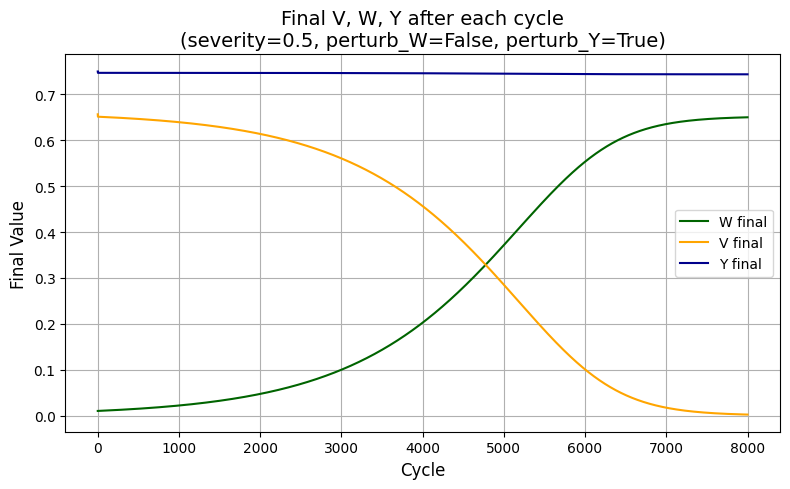

In [56]:
cycles = 8000
duration = 25.0
W0 = 0.01
X0 = W0 / (X_out / X_in)

W,Y = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
V0 = W - W0
Y0 = Y
Z0 = Y0

print(f'W0 = {W0}, V0 = {V0}, Y0 = {Y0}, X0 = {X0}, Z0 = {Z0}')

x = run_cycles(V0, W0, Y0, X0, Z0,
               W_birth, Y_birth, W_death, Y_death,
               X_in, Z_in, X_out, Z_out,
               duration, dt,
               use_X, use_Z,
               cycles,
               severity,
               perturb_W=False,
               perturb_Y=True)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def run_cycles_ext(V0, W0, Y0, X0, Z0,
                   W_birth, Y_birth, W_death, Y_death,
                   X_in, Z_in, X_out, Z_out,
                   durations, dt,
                   use_X, use_Z,
                   cycles,
                   severity,
                   perturb_W=False,
                   perturb_Y=False):
    """
    For each duration in `durations`, run `cycles` chained simulate_segment calls
    (starting from equilibrium‐based initials), record the final W each cycle,
    and plot all W_final vs. cycle curves on one axes, colored by duration via viridis.
    """

    # Prepare colormap for durations
    try:
        base_cmap = cm.colormaps['viridis']
    except AttributeError:
        base_cmap = cm.get_cmap('viridis')
    cmap = base_cmap
    norm = mcolors.Normalize(vmin=min(durations), vmax=max(durations))

    plt.figure(figsize=(8, 5))
    cycles_idx = np.arange(1, cycles + 1)

    for dur in durations:
        # equilibrium‐based initials
        W_eq, Y_eq = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
        if W_eq is None:
            raise RuntimeError("No positive equilibrium exists.")
        V_curr = W_eq - W0
        W_curr = W0
        Y_curr = Y_eq
        X_curr = W0
        Z_curr = Y_eq

        W_finals = []

        for _ in range(cycles):
            _, V_arr, W_arr, Y_arr, X_arr, Z_arr, X_plot, Z_plot = simulate_segment(
                V_curr, W_curr, Y_curr, X_curr, Z_curr,
                W_birth, Y_birth, W_death, Y_death,
                X_in, Z_in, X_out, Z_out,
                duration=dur, dt=dt,
                use_X=use_X, use_Z=use_Z,
                tol=1e-6, stop_at_eq=False
            )

            V_final = V_arr[-1]
            W_final = W_arr[-1]
            Y_final = Y_arr[-1]

            W_finals.append(W_final)

            # perturb for next cycle
            if perturb_W:
                V_curr = (1 - severity) * V_final
                W_curr = (1 - severity) * W_final
            else:
                V_curr = V_final
                W_curr = W_final

            if perturb_Y:
                Y_curr = (1 - severity) * Y_final
            else:
                Y_curr = Y_final

            X_curr = X_arr[-1]
            Z_curr = Z_arr[-1]

        # plot only W_finals vs cycles
        color = cmap(norm(dur))
        plt.plot(cycles_idx, W_finals,
                  linestyle='-',
                 color=color,
                 label=f"T={dur}")

    plt.xlabel('Cycle', fontsize=12)
    plt.ylabel(r'$W_{\mathrm{final}}$', fontsize=12)
    plt.title(f'Final W after each cycle for various durations\n'
              f'(W₀={W0}, severity={severity}, perturb_W={perturb_W}, perturb_Y={perturb_Y})',
              fontsize=14)
    plt.grid(True)

    # add colorbar for durations
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.02, aspect=30)
    cbar.set_label('Duration', fontsize=12)

    plt.legend(title='Duration', fontsize=9, title_fontsize=10)
    plt.tight_layout()
    plt.show()

/var/folders/57/ffrpkhfx7xq73dykhyvrqgw40000gn/T/ipykernel_2275/3911953234.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap('viridis')
/var/folders/57/ffrpkhfx7xq73dykhyvrqgw40000gn/T/ipykernel_2275/3911953234.py:94: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=0.02, aspect=30)


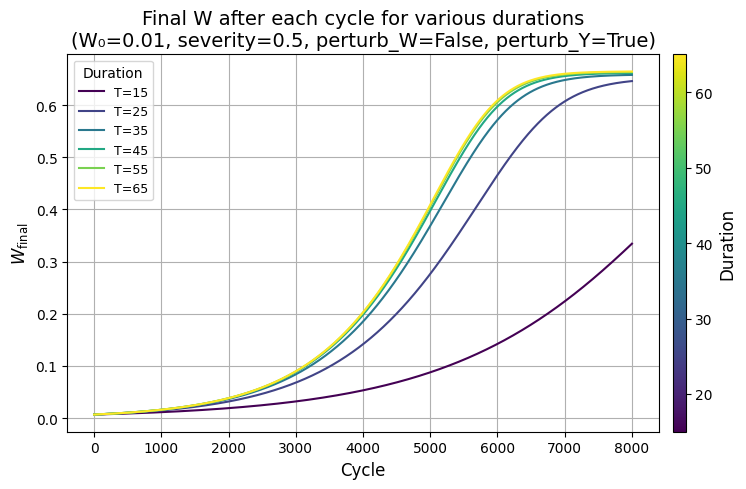

In [57]:
x = run_cycles_ext(V0, W0, Y0, X0, Z0,
               W_birth, Y_birth, W_death, Y_death,
               X_in, Z_in, X_out, Z_out,
               durations = [15, 25, 35, 45, 55, 65], dt = dt,
               use_X= use_X, use_Z = use_Z,
               cycles=
               cycles,
               severity = severity,
               perturb_W=False,
               perturb_Y=True)